# Colorizing images of flowers

A simple implementation for training neural networks to colorize images of flowers using Tensorflow and keras

### First import libraries 📚

In [1]:
import os

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

import numpy as np  
import matplotlib.pyplot as plt
import cv2

print('Tensorflow version:',tf.__version__)

Tensorflow version: 2.0.0


### Loading data 💾

In this project i use the 102 flowers dataset, which is can also be used for segmentation and classification. The data can be found at https://www.robots.ox.ac.uk/~vgg/data/flowers/102/ <br/> First we need to declare some functions to pre-process the data and store it in numpy arrays <br/> Also it is probably worth shuffling the dataset, to remove any ordering of the images that might have been applied.

In [2]:
def load_color(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (128, 128))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return np.array(img/255.0, dtype = np.float32)
    
def load_gray(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (128, 128))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return np.expand_dims(img/255.0, axis = 2).astype(np.float32)

Also, it should be noted that if the dataset is bigger, or your machine has less RAM it is worth making a data-generator<br/>A good example for a classification data generator can be found here: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

In [3]:
folder = 'data/' 
gray = np.array([load_gray(folder+f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))])
print('loaded gray images')
color = np.array([load_color(folder+f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))])
print('loaded color images')

loaded gray images
loaded color images


### Declaring the models parameters ⚙️
A good model for this type of task is a U-net, this architecture explanation can be found here: https://heartbeat.fritz.ai/deep-learning-for-image-segmentation-u-net-architecture-ff17f6e4c1cf

In [4]:
def make_colorizer_model(input_size = (128,128,3)):
    inputs = Input(input_size)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(3, (1, 1), activation='sigmoid') (c9)
    
    model = Model(inputs = inputs, outputs = outputs)

    return model

In [5]:
model = make_colorizer_model((128,128,1))
model.compile(optimizer='adam', loss='mse')

### Training the model 🧪

The gray images are given to the model as input, and the it is trained to replicate the colored image

In [6]:
history = model.fit(gray, color, epochs = 50, validation_split=0.2)

Train on 6551 samples, validate on 1638 samples
Epoch 1/50
6551/6551 [==============================] - 14s 2ms/sample - loss: 0.0252 - val_loss: 0.0197
Epoch 2/50
6551/6551 [==============================] - 8s 1ms/sample - loss: 0.0183 - val_loss: 0.0222
Epoch 3/50
6551/6551 [==============================] - 9s 1ms/sample - loss: 0.0172 - val_loss: 0.0174
Epoch 4/50
6551/6551 [==============================] - 9s 1ms/sample - loss: 0.0166 - val_loss: 0.0170
Epoch 5/50
6551/6551 [==============================] - 9s 1ms/sample - loss: 0.0162 - val_loss: 0.0158
Epoch 6/50
6551/6551 [==============================] - 9s 1ms/sample - loss: 0.0160 - val_loss: 0.0169
Epoch 7/50
6551/6551 [==============================] - 9s 1ms/sample - loss: 0.0156 - val_loss: 0.0156
Epoch 8/50
6551/6551 [==============================] - 8s 1ms/sample - loss: 0.0154 - val_loss: 0.0152
Epoch 9/50
6551/6551 [==============================] - 8s 1ms/sample - loss: 0.0152 - val_loss: 0.0159
Epoch 10/50
655

### Test the results 📉

We can then use matplotlib to view the loss over the training process to view the improvments

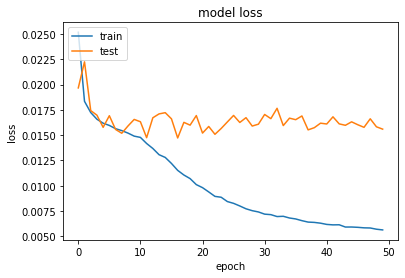

In [7]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Viewing the results👀
Once all the training is done, we can view the results to see how our model performs

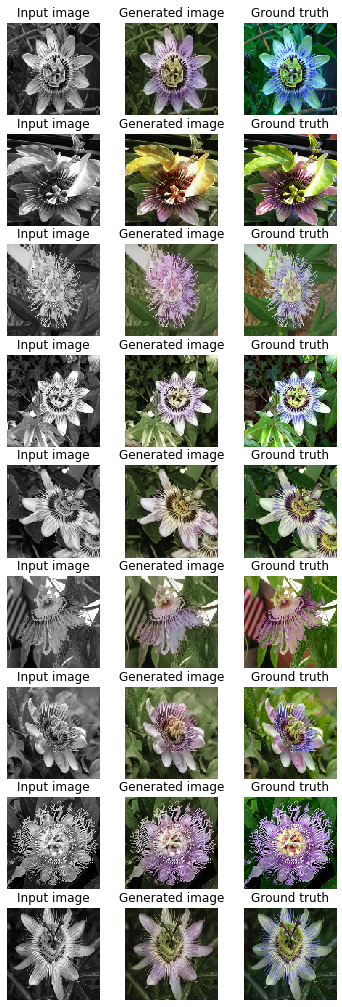

In [8]:
rows = 10
predictions = model.predict(gray[:rows])

fig=plt.figure(figsize=(6, rows*2))
for i in range(1, rows):
    fig.add_subplot(rows, 3, i*3 -2)
    plt.axis('off')   
    plt.imshow(np.squeeze(gray[i]), cmap = 'gray')
    plt.title('Input image')

    fig.add_subplot(rows, 3, i*3 -1)
    plt.axis('off')   
    plt.imshow(predictions[i]) 
    plt.title('Generated image')

    fig.add_subplot(rows, 3, i*3)
    plt.axis('off')   
    plt.imshow(color[i]) 
    plt.title('Ground truth')
plt.show()

Going forward, more data, and a more appropriate loss function would improve the results. There are already programs out there that are built for specific purposes, such as coloring back and white war photos. but it was a fun project to try out.